In [39]:
from faker import Faker
import pandas as pd
import random
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
fake = Faker()
Faker.seed(42)
random.seed(42)

# Static options
states = [fake.state_abbr() for _ in range(50)]
vehicle_types = ['Sedan', 'SUV', 'Truck', 'Van', 'Coupe']
reported_by_options = ['insured', 'claimant']

# Incident types mapped to realistic fact-of-loss scenarios
incident_map = {
    'Rear-end Collision': [
        "V2 rear-ended V1 while stopped at a red light",
        "V2 failed to stop and struck V1 from behind"
    ],
    'Side-impact': [
        "V2 ran a stop sign and hit the side of V1",
        "V2 turned left and struck the side of V1"
    ],
    'Theft': [
        "V1 was reported stolen from insured’s driveway",
        "V1 was missing after being parked overnight"
    ],
    'Weather Damage': [
        "V1 was damaged by falling tree during storm",
        "Hailstorm caused significant roof and hood damage to V1"
    ],
    'Head-on Collision': [
        "V2 crossed centerline and hit V1 head-on",
        "V2 entered wrong lane and collided with V1"
    ],
    'Backing Collision': [
        "V1 struck V2 while reversing from parking spot",
        "V2 was behind V1 when it began backing up"
    ]
}
# Global set to track generated claim IDs
generated_ids = set()

In [32]:
def generate_unique_claim_id():
    chars = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    while True:
        claim_id = ''.join(random.choices(chars, k=9))
        if claim_id not in generated_ids:
            generated_ids.add(claim_id)
            return claim_id
            
def is_fraudulent(days_to_incident, claim_amount, policy_limit, prior_claims, reported_by, incident_type):
    score = 0

    if days_to_incident < 7:
        score += 1
    if claim_amount > policy_limit * 0.8:
        score += 1
    if prior_claims >= 2:
        score += 1
    if reported_by == 'claimant':
        score += 1
    if incident_type in ['Theft', 'Weather Damage']:
        score += 1

    return 1 if score >= 3 else 0
    
def generate_claim():
    policy_start = fake.date_between(start_date='-3y', end_date='-90d')
    days_to_incident = random.randint(5, 365)
    incident_date = policy_start + timedelta(days=days_to_incident)
    policy_limit = random.choice([15000, 25000, 50000, 100000])
    claim_amount = round(random.uniform(1000, policy_limit), 2)
    insured_age = random.randint(18, 80)
    prior_claims = random.randint(0, 5)
    
    # Random pick for incident type and linked fact of loss
    incident_type = random.choice(list(incident_map.keys()))
    fact_of_loss = random.choice(incident_map[incident_type])
    reported_by = random.choice(reported_by_options)

    # Fraud rule
    fraud_flag = is_fraudulent( days_to_incident, claim_amount,  policy_limit, prior_claims, reported_by, incident_type)

    severity = round(claim_amount / policy_limit, 2)

    return {
        "claim_id": generate_unique_claim_id(),
        "policy_start": policy_start,
        "incident_date": incident_date,
        "claim_amount": claim_amount,
        "state": random.choice(states),
        "vehicle_type": random.choice(vehicle_types),
        "incident_type": incident_type,
        "fact_of_loss": fact_of_loss,
        "reported_by": reported_by,
        "policy_limit": policy_limit,
        "insured_age": insured_age,
        "prior_claims_count": prior_claims,
        "fraud_flag": int(fraud_flag),
        "severity_score": severity
    }


In [34]:
# Generate and preview
claims = [generate_claim() for _ in range(1000)]
df_claims = pd.DataFrame(claims)

In [36]:
df_claims.head()

,claim_id,policy_start,incident_date,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score
0,PL2U5CFP3,2023-01-04,2024-01-01,10556.23,WA,Sedan,Backing Collision,V1 struck V2 while reversing from parking spot,insured,15000,18,0,0,0.70
1,P6MPB4DPG,2024-04-11,2024-09-26,5721.65,WA,Van,Side-impact,V2 turned left and struck the side of V1,claimant,15000,73,5,0,0.38
2,6X3B9KYHK,2024-09-01,2025-07-07,14030.50,FL,Sedan,Head-on Collision,V2 entered wrong lane and collided with V1,insured,15000,63,5,0,0.94
3,BW9KCKWDH,2024-06-09,2024-09-26,1042.06,GA,Truck,Rear-end Collision,V2 rear-ended V1 while stopped at a red light,claimant,15000,40,1,0,0.07
4,FNCC8UUXO,2023-11-06,2024-09-21,24036.26,VT,Coupe,Side-impact,V2 turned left and struck the side of V1,claimant,25000,40,2,1,0.96


# EDA On Faker data

In [42]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   claim_id            1000 non-null   object 
 1   policy_start        1000 non-null   object 
 2   incident_date       1000 non-null   object 
 3   claim_amount        1000 non-null   float64
 4   state               1000 non-null   object 
 5   vehicle_type        1000 non-null   object 
 6   incident_type       1000 non-null   object 
 7   fact_of_loss        1000 non-null   object 
 8   reported_by         1000 non-null   object 
 9   policy_limit        1000 non-null   int64  
 10  insured_age         1000 non-null   int64  
 11  prior_claims_count  1000 non-null   int64  
 12  fraud_flag          1000 non-null   int64  
 13  severity_score      1000 non-null   float64
dtypes: float64(2), int64(4), object(8)
memory usage: 109.5+ KB


<Axes: xlabel='fraud_flag', ylabel='count'>

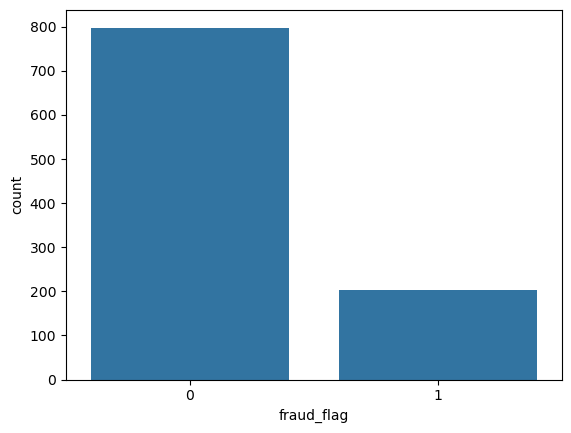

In [48]:
sns.countplot(x='fraud_flag', data=df_claims)

<Axes: xlabel='claim_amount', ylabel='Count'>

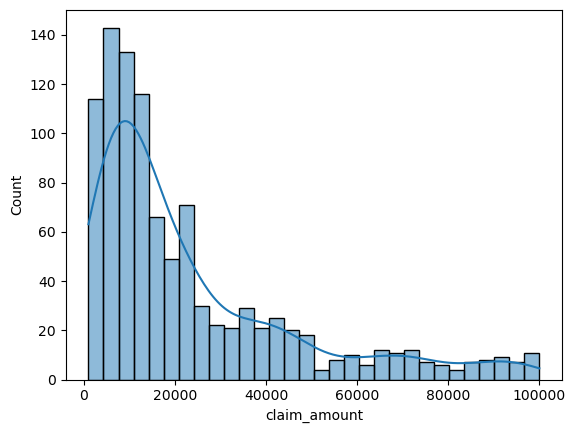

In [50]:
sns.histplot(df_claims['claim_amount'], bins=30, kde=True)

<Axes: ylabel='Count'>

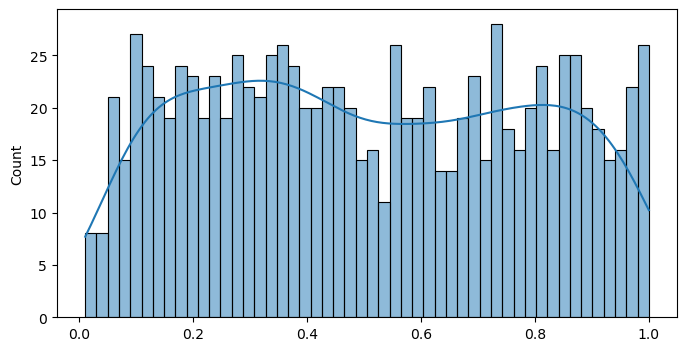

In [76]:
claim_limit_ratio = df_claims['claim_amount'] / df_claims['policy_limit']
plt.figure(figsize=(8, 4))
sns.histplot(claim_limit_ratio, bins=50, kde=True)

<Axes: >

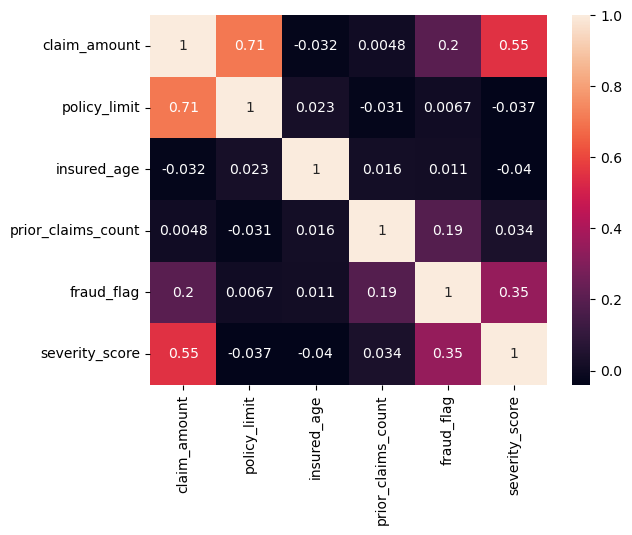

In [74]:
sns.heatmap(df_claims.corr(numeric_only=True), annot=True)

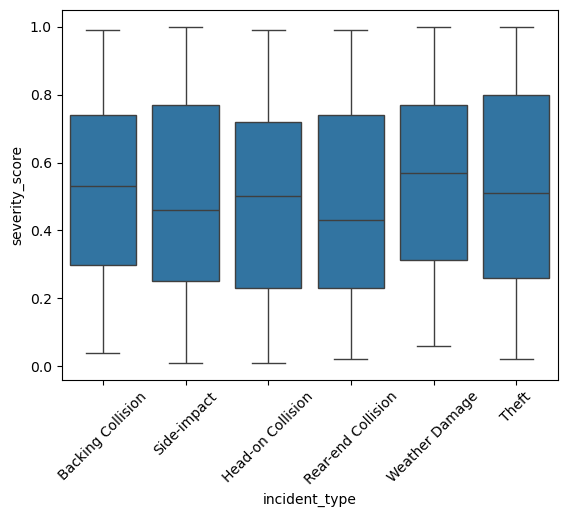

In [86]:
sns.boxplot(x='incident_type', y='severity_score', data=df_claims)
plt.xticks(rotation=45)
plt.show()